In [23]:
import numpy as np
import pandas as pd

from scipy.stats import skew

from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [24]:
# Caminho dos dados.
DTRAIN_PATH = "data/train.csv"
DTEST_PATH = "data/test.csv"

# Funções auxiliares.
def reading_data(path):
    return pd.read_csv(path)

# def rmse_cv(model, x_train, y_train, k_folds=10):
#     return np.sqrt(-cross_val_score(model, x_train, y_train,
#         scoring="neg_mean_squared_error", cv=k_folds))

In [25]:
def pre_processing_data(train, test):
    #Now drop the  'Id' colum since it's unnecessary for  the prediction process.
    train.drop("Id", axis = 1, inplace = True)
    test.drop("Id", axis = 1, inplace = True)

    #Manually removing outliers.
    train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

    
    # Aplicando Log nos preços de venda (valores em distribuição normal).
    train["SalePrice"] = np.log1p(train["SalePrice"])

    # Concatenando dados de treino e teste para facilitar as operações
    # de pré processamento.

    ntrain = train.shape[0]
    ntest = test.shape[0]
    y_train = train.SalePrice.values

    all_data = pd.concat((train, test)).reset_index(drop=True)
    all_data.drop(['SalePrice'], axis=1, inplace=True)
     
    all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
    all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
    all_data["Alley"] = all_data["Alley"].fillna("None")
    all_data["Fence"] = all_data["Fence"].fillna("None")
    all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

    #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        all_data[col] = all_data[col].fillna('None')
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)

    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)
    
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        all_data[col] = all_data[col].fillna('None')
    
    all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
    
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data = all_data.drop(['Utilities'], axis=1)
    all_data["Functional"] = all_data["Functional"].fillna("Typ")
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
    
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
    
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
    all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


    #MSSubClass=The building class
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


    #Changing OverallCond into a categorical variable
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)


    #Year and month sold are transformed into categorical features.
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)
    
    from sklearn.preprocessing import LabelEncoder
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold')

    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(all_data[c].values)) 
        all_data[c] = lbl.transform(list(all_data[c].values))

    # Adding total sqfootage feature 
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']



    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    
    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        all_data[feat] = boxcox1p(all_data[feat], lam)    
    
    
    # Converte dados categorigos em dummy indicators
    all_data = pd.get_dummies(all_data)


    # Dados para treinamento e teste após pré processamento.
    x_train = all_data[:ntrain]
    x_test = all_data[ntrain:] 

    return (x_train, y_train, x_test)


train_data = reading_data(DTRAIN_PATH)
test_data = reading_data(DTEST_PATH)

test_ID = test_data['Id']
train_x, train_y, test_x = pre_processing_data(train_data, test_data)


In [26]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# import lightgbm as lgb

In [30]:
# Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_x.values)
    rmse= np.sqrt(-cross_val_score(model, train_x.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [31]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [32]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1099 (0.0140)

ElasticNet score: 0.1098 (0.0141)

Kernel Ridge score: 0.1132 (0.0140)



In [39]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   



In [40]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1132 (0.0140)



In [41]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [42]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1132 (0.0140)


In [44]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

stacked_averaged_models.fit(train_x.values, train_y)
stacked_train_pred = stacked_averaged_models.predict(train_x.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_x.values))
print(rmsle(train_y, stacked_train_pred))

model_xgb.fit(train_x, train_y)
xgb_train_pred = model_xgb.predict(train_x)
xgb_pred = np.expm1(model_xgb.predict(test_x))
print(rmsle(train_y, xgb_train_pred))

lasso.fit(train_x, train_y)
lasso_train_pred = lasso.predict(train_x)
lasso_pred = np.expm1(lasso.predict(test_x))
print(rmsle(train_y, xgb_train_pred))

averaged_models.fit(train_x.values, train_y)
averaged_train_pred = averaged_models.predict(train_x.values)
averaged_pred = np.expm1(averaged_models.predict(test_x.values))
print(rmsle(train_y, averaged_train_pred))

# model_lgb.fit(train_x, train_y)
# lgb_train_pred = model_lgb.predict(train_x)
# lgb_pred = np.expm1(model_lgb.predict(test_x.values))
# print(rmsle(train_y, lgb_train_pred))

'''RMSE on the entire Train data when averaging'''

# print(rmsle(train_y,stacked_train_pred*0.70 +
#                xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

# ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

print('RMSLE score on train data A:')
print(rmsle(train_y,stacked_train_pred*0.70 + xgb_train_pred*0.30 ))
ensemble = stacked_pred*0.70 + xgb_pred*0.30
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_a.csv',index=False)

print('RMSLE score on train data B:')
print(rmsle(train_y,stacked_train_pred*0.30 + xgb_train_pred*0.70 ))
ensemble = stacked_pred*0.30 + xgb_pred*0.70
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_b.csv',index=False)

print('RMSLE score on train data C:')
print(rmsle(train_y,lasso_train_pred*0.70 + xgb_train_pred*0.30 ))
ensemble = lasso_pred*0.70 + xgb_pred*0.30
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_c.csv',index=False)

print('RMSLE score on train data D:')
print(rmsle(train_y,lasso_train_pred*0.30 + xgb_train_pred*0.70 ))
ensemble = lasso_pred*0.30 + xgb_pred*0.70
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_d.csv',index=False)




0.07815719379164082
0.07879894799249872
0.07879894799249872
0.07995258539786987
RMSLE score on train data A:
0.07629888694665632
RMSLE score on train data B:
0.07656245971072871
RMSLE score on train data C:
0.0920294890551186
RMSLE score on train data D:
0.08269905463256697
RMSLE score on train data Averaged:
0.07862270647882419


NameError: name 'averaged_' is not defined

In [45]:
print('RMSLE score on train data Averaged:')
print(rmsle(train_y,stacked_train_pred*0.70 + 0.3*averaged_train_pred ))
ensemble = stacked_pred*0.70 + averaged_pred*0.30
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_avg.csv',index=False)

RMSLE score on train data Averaged:
0.07862270647882419


In [49]:
sub = pd.DataFrame()
sub['Id'] = test_ID

sub['SalePrice'] = stacked_pred*0.70 + averaged_pred*0.30
sub.to_csv('submission_7stacked_3avg.csv',index=False)
################# MELHORRRR #################
sub['SalePrice'] = stacked_pred*0.30 + averaged_pred*0.70
sub.to_csv('submission_3stacked_7avg.csv',index=False)

sub['SalePrice'] = stacked_pred*0.25 + averaged_pred*0.75
sub.to_csv('submission_25stacked_75avg.csv',index=False)


In [51]:
sub['SalePrice'] = averaged_pred
sub.to_csv('submission_100avg.csv',index=False)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.set_style('darkgrid')

# DATA VISUALIZATION

train_data = reading_data(DTRAIN_PATH)
test_data = reading_data(DTEST_PATH)

# test_ID = test_data['Id']
# train_x, train_y, test_x = pre_processing_data(train_data, test_data)

all_data = pd.concat((train_data, test_data)).reset_index(drop=True)


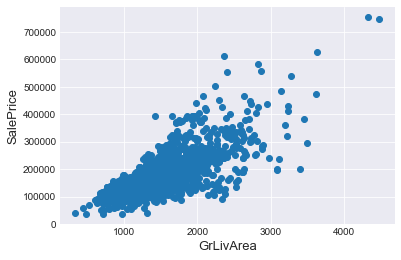

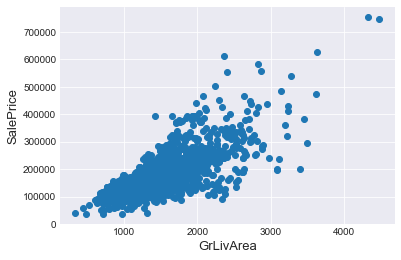

In [58]:
# Removing Outliers
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.savefig('figures/outlier1.png')

#Deleting outliers
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.savefig('figures/outlier2.png')

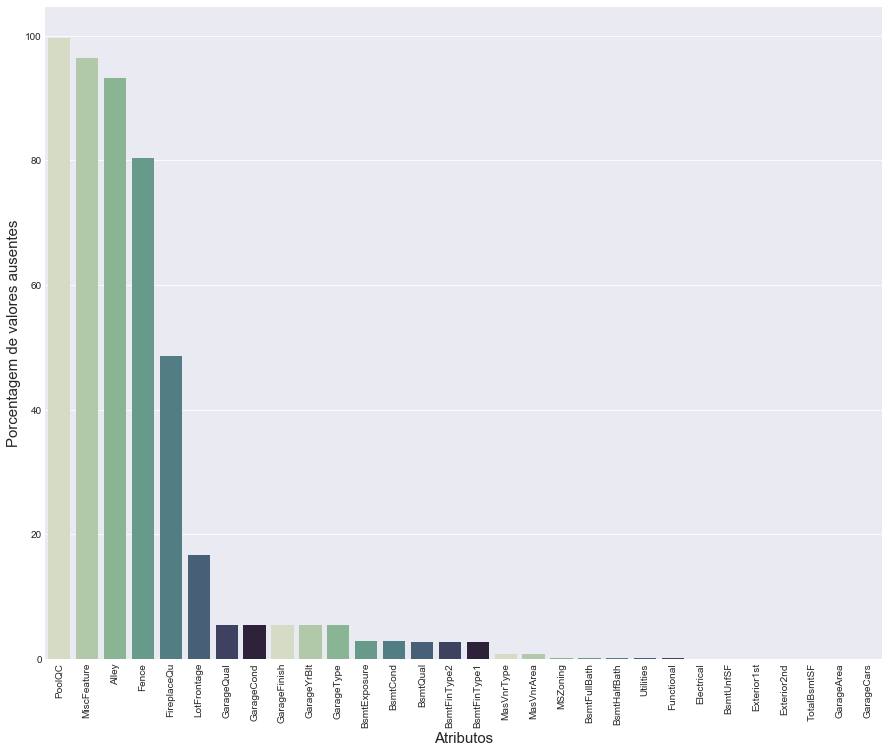

In [57]:
# MISSING VALUES
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True) 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na, palette=color)
plt.xlabel('Atributos', fontsize=15)
plt.ylabel('Porcentagem de valores ausentes', fontsize=15)
plt.savefig('figures/missing.png')

c:\users\marco\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


NameError: name 'train' is not defined

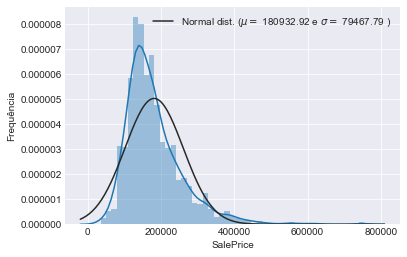

In [70]:
from scipy import stats
from scipy.stats import norm

# SALES PRICES NORMALIZATION

sns.distplot(train_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} e $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
# plt.title('SalePrice distribution')
plt.savefig('figures/SalePrice.png')


#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train_data["SalePrice"])

#Check the new distribution 
sns.distplot(train_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} e $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
# plt.title('SalePrice distribution')
plt.savefig('figures/SalePrice_normalized.png')



